In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from keras_tqdm import TQDMNotebookCallback

In [5]:
from bitstring import BitArray  #To perform bit manipulation
from keras.preprocessing.sequence import pad_sequences

def datamatrix_multiclass(tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    #tfrecord holds data in binary sequence string. 
    records = list(tf.python_io.tf_record_iterator(tfrecord))  #records holds the array of the tfrecord file
    if(tfrecord == '../data/preprocessed/unbaltrain_spotting_gunshots_subset.tfrecord'):
        print("Total audioframes in training dataset:", len(records))
    elif(tfrecord == '../data/preprocessed/eval_spotting_gunshots_subset.tfrecord'):
        print("Total audioframes in eval dataset:", len(records))
        
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]  # Make train_set & CV_set 
    print("After fractioning:")
    if(tfrecord == '../data/preprocessed/unbaltrain_spotting_gunshots_subset.tfrecord'):
        print("Total audioframes in training dataset:", len(records))
    elif(tfrecord == '../data/preprocessed/eval_spotting_gunshots_subset.tfrecord'):
        print("Total audioframes in eval dataset:", len(records))
    
    rec_len = len(records)  # this is your train set, rest is CV_set
    shuffle = np.random.permutation(range(rec_len))
    #num_batches = rec_len//batch_size - 1                      
    #j = 0
    
    
    classes = ["gun","firework","background", "other"]
    dict_classes = dict.fromkeys(classes)
    
    gun_labels = [426,427,428,429,430,431]
    fireworks_labels = [432,433,434]
    background_labels= [506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526]
    other_labels =[]
    
    while True:
        X = []
        y = []  #add g=[],f=[],b=[],other=[]
        
        for idx in shuffle[0:rec_len]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            dict_classes = {
                "gun":int(any((True for x in example_label if x in gun_labels))),
                "firework":int(any((True for x in example_label if x in fireworks_labels))),
                "background":int(any(True for x in example_label if x in background_labels)),
                "other": 0
            }
            if (sum(dict_classes.values()) == 0):
                y.append(3) # other class
            elif (sum(dict_classes.values()) >1):
                dict_classes  = dict.fromkeys(dict_classes, 0)
                continue;  # skip this iteration since the audioframe contains co-occurence of our classes 
            elif (sum(dict_classes.values()) == 1):
                if (dict_classes["gun"] == 1):
                    y.append(0)
                if (dict_classes["firework"] == 1):
                    y.append(1)
                if (dict_classes["background"] == 1):
                    y.append(2)
                if (dict_classes["other"] == 1):
                    y.append(3)
                                
            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32)) # audio_frame gets 128 8 bit numbers on each for loop iteration
            #remove pad because we are avg the audio_frame over time
#             pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)] 
            # if clip is less than 10 sec, audio_frame is padded with zeros for 
            #rest of the secs to make it to 10 sec.
            
            #adding averaging
            avg_audioframe = np.mean(audio_frame, axis = 0)
            
            #comment bottom
#             audio_frame += pad
            X.append(avg_audioframe) 

#         j += 1
#         if j >= num_batches:
#             shuffle = np.random.permutation(range(rec_len))
#             j = 0

        X = np.array(X)
        print("size of X",len(X))
        print("size of y",len(y))
        return X, np.array(y)

In [6]:
audio_train,labels_train = datamatrix_multiclass('../data/preprocessed/unbaltrain_spotting_gunshots_subset.tfrecord')

Total audioframes in training dataset: 23385
After fractioning:
Total audioframes in training dataset: 23385
size of X 23369
size of y 23369


In [7]:
print("Dimension of training matrix:",len(audio_train),"x",len(audio_train[0]))

Dimension of training matrix: 23369 x 128


In [8]:
print(audio_train[0])
# print(len(audio_train[0][0]))
print(type(audio_train[0]))
print(type(audio_train[0][0]))

print((audio_train[0]).shape)
print(audio_train[0][0].shape)


[ 60.9  68.1 168.8  46.5 122.2 133.3  59.6 120.2 181.1 133.6  54.9 112.9
 180.6 173.5  60.8  85.8 194.   55.1  73.2 250.5 157.  132.2  96.  137.9
  73.9 140.2  55.9  22.9 167.2 124.7 112.4 173.9 136.5 165.  185.2 137.1
  48.8 148.6 124.5  58.7  46.2 151.1  18.5   6.8 116.4  18.5  62.7  59.9
 158.4  73.2 105.8  50.9  67.7 142.7  80.3 208.3 124.4 189.4 158.4  53.9
 108.9 224.2  81.7 206.6 172.4  87.9  74.9  32.1 163.  152.5  33.3 201.2
 211.9 219.7 154.7 116.4 155.7  86.9  66.7 209.6  69.5 116.  151.  203.1
 152.  191.2 233.  158.  198.5 208.9 218.6 231.9 158.3 118.4 216.8 150.3
 109.4  68.7 101.3 190.7 119.7 152.8  63.9 232.3  31.   20.5 116.9 199.
  33.   41.9 159.4  19.3 213.6 174.1 235.3 131.4 234.8  51.   91.8 185.7
 106.6 172.  177.4 138.6 101.2  36.3  69.7 147.1]
<class 'numpy.ndarray'>
<class 'numpy.float32'>
(128,)
()


In [9]:
labels_train


array([2, 3, 3, ..., 3, 3, 3])

In [10]:
gun_count=0
background_count = 0
firework_count = 0
other_count =0 
for i in range(0,len(labels_train)):
    if(labels_train[i] == 0):
        gun_count = gun_count+1
    if(labels_train[i] == 2):
        background_count = background_count+1
    if(labels_train[i] == 1):
        firework_count = firework_count+1
    if(labels_train[i] == 3):
        other_count= other_count+1
print("gun labels:",gun_count)
print("firework labels:",firework_count)
print("background labels:",background_count)
print("other labels:",other_count)

gun labels: 86
firework labels: 61
background labels: 2192
other labels: 21030


In [11]:
# %pylab inline
# # import mdtraj as md
# from sklearn.decomposition import PCA


# def get_pca(features):
#     pca = PCA(n_components=2)
#     transformed = pca.fit(features).transform(features)
#     scaler = MinMaxScaler()
#     scaler.fit(transformed)
#     return scaler.transform(transformed)

# pca_vggish = get_pca(audio_train)

# print(pca_vggish.shape)

# mfcc_key = 'pca_vggish'

# # all_json[mfcc_key] = transform_numpy_to_json(pca_vggish)
# #all_json[wavenet_key] = transform_numpy_to_json(pca_wavenet)

# plt.figure(figsize=(30, 30))
# _ = plt.scatter(pca_vggish.T[0],
#                 pca_vggish.T[1])#, pca_vggish.T[2])
# xlabel('PC1')
# ylabel('PC2')
# title('Plot of Embeddings along the PC vectors')
# plt.show()

# # ax = plt.axes(projection='3d')
# # ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

Populating the interactive namespace from numpy and matplotlib


NameError: name 'MinMaxScaler' is not defined

Explained variation per principal component: [0.02397207 0.02219298 0.02023628]


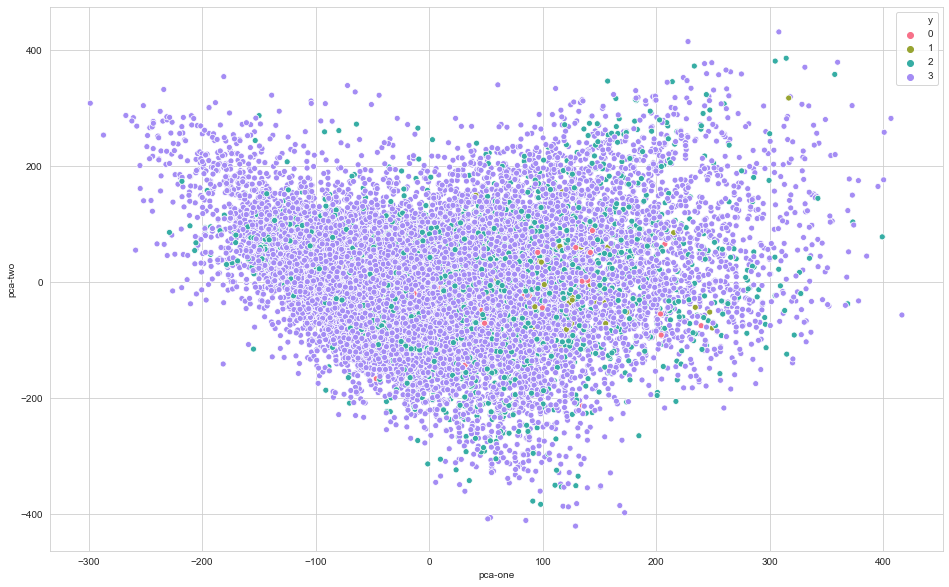

In [12]:
import seaborn as sns
#PCA in 3 dimensions
df_pca  = pd.DataFrame(audio_train)
df_pca['y'] = labels_train
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_pca) #audio_train)
df_pca['pca-one'] = pca_result[:,0]
df_pca['pca-two'] = pca_result[:,1] 
df_pca['pca-three'] = pca_result[:,2]
# Now you have 3 more coloumns on your df_pca dataframe
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#Explained variation per principal component: [0.09746116 0.07155445 0.06149531]

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_pca.shape[0])


# sns.palplot(sns.hls_palette(8, l=.3, s=.8))
# two dimensional plot
plt.figure(figsize=(16,10))
sns.set_style("whitegrid")
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue= "y",
    palette=sns.color_palette("husl", 4),
#     palette=sns.hls_palette(4, l=.3, s=.8),
#     palette=sns.color_palette("cubehelix", 4),
    data=df_pca.loc[rndperm,:],
    legend="full",
#     alpha=1
)



# # three dimensional PCA plot
# plt.figure(figsize=(16,10))#.gca(projection='3d')
# scatter(
#     x=df_pca.loc[rndperm,:]["pca-one"], 
#     y=df_pca.loc[rndperm,:]["pca-two"], 
#     z=df_pca.loc[rndperm,:]["pca-three"], 
#     c=df_pca.loc[rndperm,:]["y"], 
# #     cmap='tab10'
# )
# ax.set_xlabel('pca-one')
# ax.set_ylabel('pca-two')
# ax.set_zlabel('pca-three')
# plt.show()

# # With Seaborn
# from matplotlib.pyplot import figure
# figure(figsize=(16, 10))
# sns.scatterplot(x='AveRooms', y='AveBedrms', data=train_df, 
#                 label="Average Bedrooms");


# # Attributes of interest
# cols = ['density', 
#         'residual sugar', 
#         'total sulfur dioxide', 
#         'fixed acidity', 
#         'wine_type']
        
# pp = sns.pairplot(data=wines[cols], 
#                   hue='wine_type', # <== 😀 Look here!
#                   size=1.8, aspect=1.8, 
#                   palette={"red": "#FF9999", "white": "#FFE888"},
#                   plot_kws=dict(edgecolor="black", linewidth=0.5))
# fig = pp.fig 
# fig.subplots_adjust(top=0.93, wspace=0.3)
# fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

# # trial 3
# cols = ['pca-one', 'pca-two', 'pca-three']
# pp = sns.pairplot(data = df_pca[cols], hue = df_pca['y'].T, size = 1.8, aspect=1.8, palette={"red": "#FF9999", "white": "#FFE888"},
#                   plot_kws=dict(edgecolor="black", linewidth=0.5))

# fig = pp.fig
# fig.subplots_adjust(top=0.93, wspace=0.3)
# fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)



In [13]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import MinMaxScaler
# #default perplexity = 30, iteration = 250 atleast
# embedding = TSNE(n_components=2,
#                      perplexity=40,
#                      n_iter=iteration).fit_transform(audio_train)

NameError: name 'iteration' is not defined

In [ ]:
# print("shape of embeddings: ", embedding.shape)

In [ ]:
plt.figure(figsize=(16, 10))
_ = plt.scatter(embedding[0],
                embedding[1])#, pca_vggish.T[2])
xlabel('tSNE 0')
ylabel('tSNE 1')
title('Plot of Embeddings in tSNE space')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 23369 samples in 0.179s...
[t-SNE] Computed neighbors for 23369 samples in 137.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23369
[t-SNE] Computed conditional probabilities for sample 2000 / 23369
[t-SNE] Computed conditional probabilities for sample 3000 / 23369
[t-SNE] Computed conditional probabilities for sample 4000 / 23369
[t-SNE] Computed conditional probabilities for sample 5000 / 23369
[t-SNE] Computed conditional probabilities for sample 6000 / 23369
[t-SNE] Computed conditional probabilities for sample 7000 / 23369
[t-SNE] Computed conditional probabilities for sample 8000 / 23369
[t-SNE] Computed conditional probabilities for sample 9000 / 23369
[t-SNE] Computed conditional probabilities for sample 10000 / 23369
[t-SNE] Computed conditional probabilities for sample 11000 / 23369
[t-SNE] Computed conditional probabilities for sample 12000 / 23369
[t-SNE] Computed conditional probabilities for 

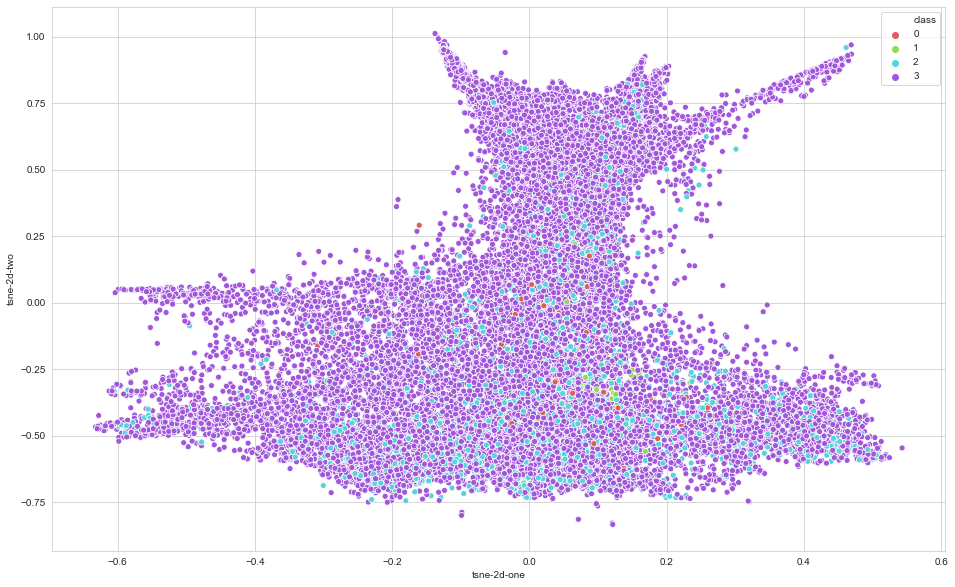

In [17]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 23369 samples in 0.174s...
[t-SNE] Computed neighbors for 23369 samples in 138.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23369
[t-SNE] Computed conditional probabilities for sample 2000 / 23369
[t-SNE] Computed conditional probabilities for sample 3000 / 23369
[t-SNE] Computed conditional probabilities for sample 4000 / 23369
[t-SNE] Computed conditional probabilities for sample 5000 / 23369
[t-SNE] Computed conditional probabilities for sample 6000 / 23369
[t-SNE] Computed conditional probabilities for sample 7000 / 23369
[t-SNE] Computed conditional probabilities for sample 8000 / 23369
[t-SNE] Computed conditional probabilities for sample 9000 / 23369
[t-SNE] Computed conditional probabilities for sample 10000 / 23369
[t-SNE] Computed conditional probabilities for sample 11000 / 23369
[t-SNE] Computed conditional probabilities for sample 12000 / 23369
[t-SNE] Computed conditional probabilities for 

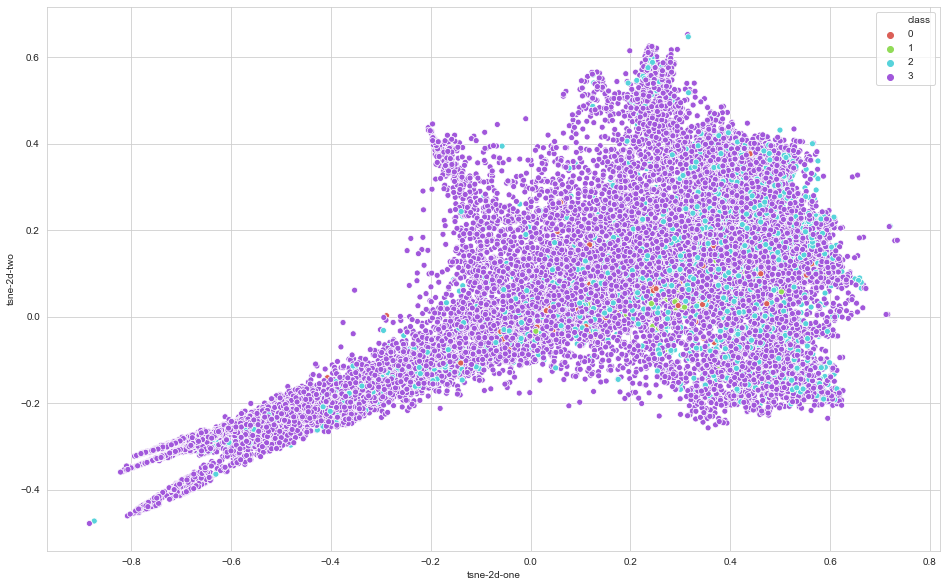

In [18]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23369 samples in 0.179s...
[t-SNE] Computed neighbors for 23369 samples in 135.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23369
[t-SNE] Computed conditional probabilities for sample 2000 / 23369
[t-SNE] Computed conditional probabilities for sample 3000 / 23369
[t-SNE] Computed conditional probabilities for sample 4000 / 23369
[t-SNE] Computed conditional probabilities for sample 5000 / 23369
[t-SNE] Computed conditional probabilities for sample 6000 / 23369
[t-SNE] Computed conditional probabilities for sample 7000 / 23369
[t-SNE] Computed conditional probabilities for sample 8000 / 23369
[t-SNE] Computed conditional probabilities for sample 9000 / 23369
[t-SNE] Computed conditional probabilities for sample 10000 / 23369
[t-SNE] Computed conditional probabilities for sample 11000 / 23369
[t-SNE] Computed conditional probabilities for sample 12000 / 23369
[t-SNE] Computed conditional probabilities for s

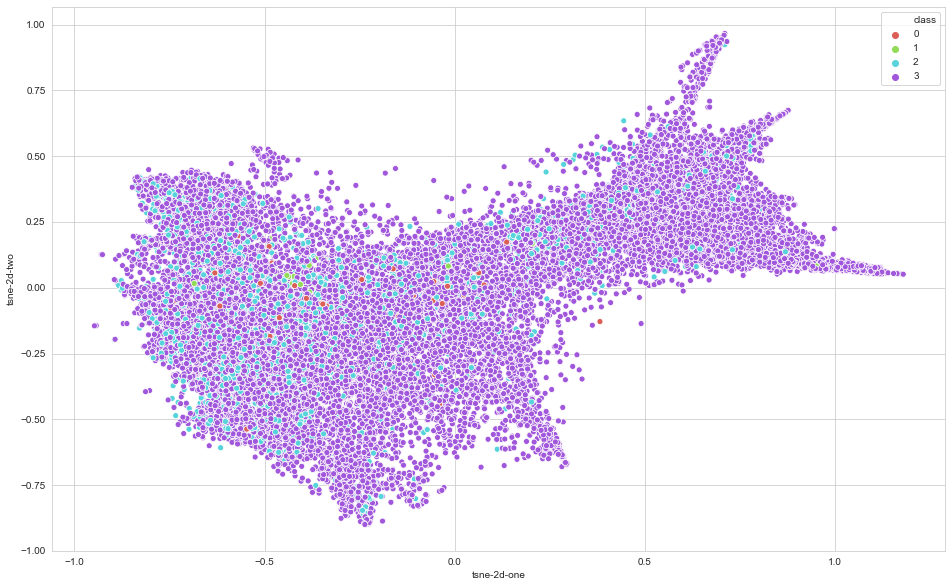

In [19]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 23369 samples in 0.212s...
[t-SNE] Computed neighbors for 23369 samples in 136.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23369
[t-SNE] Computed conditional probabilities for sample 2000 / 23369
[t-SNE] Computed conditional probabilities for sample 3000 / 23369
[t-SNE] Computed conditional probabilities for sample 4000 / 23369
[t-SNE] Computed conditional probabilities for sample 5000 / 23369
[t-SNE] Computed conditional probabilities for sample 6000 / 23369
[t-SNE] Computed conditional probabilities for sample 7000 / 23369
[t-SNE] Computed conditional probabilities for sample 8000 / 23369
[t-SNE] Computed conditional probabilities for sample 9000 / 23369
[t-SNE] Computed conditional probabilities for sample 10000 / 23369
[t-SNE] Computed conditional probabilities for sample 11000 / 23369
[t-SNE] Computed conditional probabilities for sample 12000 / 23369
[t-SNE] Computed conditional probabilities for sa

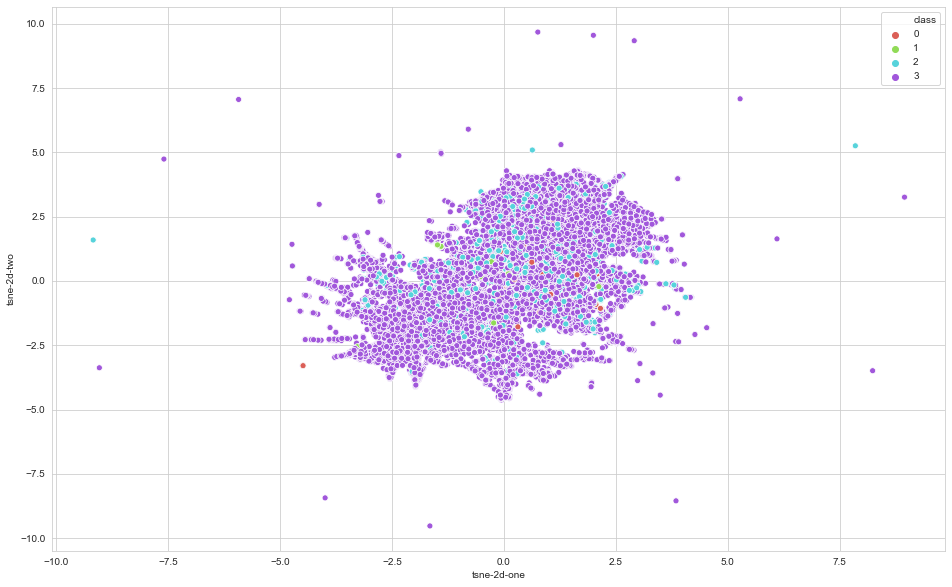

In [20]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 23369 samples in 0.165s...


In [ ]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import MinMaxScaler


# def get_scaled_tsne_embeddings(features, perplexity, iteration):
#     embedding = TSNE(n_components=2,
#                      perplexity=perplexity,
#                      n_iter=iteration).fit_transform(features)
#     scaler = MinMaxScaler()
#     scaler.fit(embedding)
#     return scaler.transform(embedding)


# tnse_embeddings_mfccs = []
# # perplexities = [2, 5, 30, 50, 100]
# # iterations = [250, 500, 1000, 2000, 5000]
# perplexities = [2]
# iterations = [250]

# for perplexity in perplexities:
#     for iteration in iterations:
#         tsne_mfccs = get_scaled_tsne_embeddings(audio_train,
#                                                 perplexity,
#                                                 iteration)

        

In [ ]:
# tnse_embeddings_mfccs.append(tsne_mfccs)  
# mfcc_key = 'tsnemfcc{}{}'.format(i, j) 
# all_json[mfcc_key] = transform_numpy_to_json(tsne_mfccs)

In [ ]:
# fig, ax = plt.subplots(nrows=len(perplexities), 
#                        ncols=len(iterations),
#                        figsize=(30, 30))

# for i, row in enumerate(ax):
#     for j, col in enumerate(row):
#         current_plot = i * len(iterations) + j
#         col.scatter(tnse_embeddings_mfccs[current_plot].T[0], 
#                     tnse_embeddings_mfccs[current_plot].T[1], 
#                     s=1)
# plt.show()